### XGB model

In [1]:
import pandas as pd

# load dataset
df = pd.read_csv('cleaned_loan.csv')
df.head()

,age,education,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default,proof_Aadhar,proof_Driving,proof_PAN,proof_Passport,proof_VoterID,loan_amount_log,asset_cost_log,loan_to_value_ratio_log,debt_load_ratio_log
0,27,1,504264,820920,2,2,0,0,1,0,0,0,0,13.130857,13.618182,0.964215,0.666667
1,48,1,728556,831444,6,2,0,0,1,0,0,0,0,13.498821,13.630920,0.990309,0.285714
2,30,2,642936,826092,0,0,0,1,0,0,0,0,1,13.373802,13.624463,0.981602,0.000000
3,28,1,746556,930924,0,0,0,0,1,0,0,0,0,13.523227,13.743934,0.983942,0.000000
4,29,1,1139880,1902000,0,0,0,0,1,0,0,0,0,13.946434,14.458417,0.964589,0.000000


In [2]:
# assign features
X = df[['age', 'education', 'last_delinq_none', 'loan_to_value_ratio_log', 'debt_load_ratio_log']]
y = df['loan_default']

In [3]:
from sklearn.model_selection import train_test_split

# split into training and validation sets (90 10)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# List of columns to scale
columns_to_scale = ['age', 'loan_to_value_ratio_log', 'debt_load_ratio_log']

# Scale the selected columns in the training data
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

# Scale the same columns in the validation data
X_valid[columns_to_scale] = scaler.transform(X_valid[columns_to_scale])

In [5]:
from xgboost import XGBClassifier

# XGBoost baseline model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# predict valid 
y_pred = xgb_model.predict(X_valid)
print("XGB Based Model:")

# training accuracy
trainAccuracy = xgb_model.score(X_train, y_train)
print("Training Accuracy:", trainAccuracy)

# valid accuracy
validAccuracy = accuracy_score(y_valid, y_pred)
print("Validation Accuracy:", validAccuracy)

# precison recall f1score
print(classification_report(y_valid, y_pred))

XGB Based Model:
Training Accuracy: 0.7892745517354828
Validation Accuracy: 0.5636094674556213
              precision    recall  f1-score   support

           0       0.61      0.74      0.67       402
           1       0.44      0.30      0.36       274

    accuracy                           0.56       676
   macro avg       0.53      0.52      0.51       676
weighted avg       0.54      0.56      0.54       676



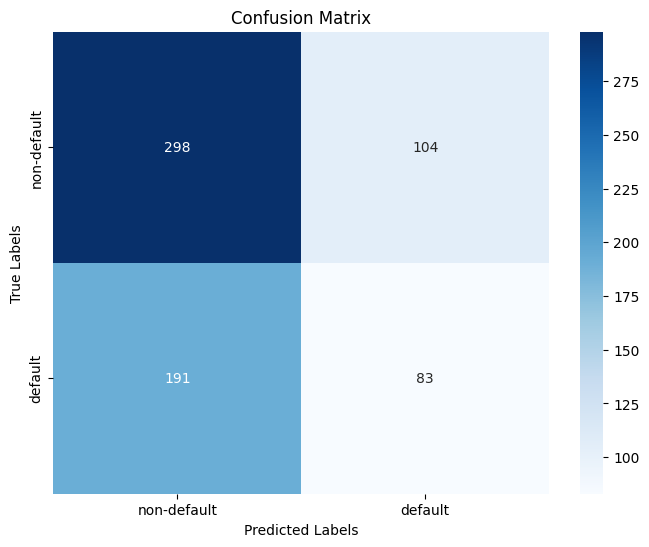

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Define custom labels
custom_labels = ['non-default', 'default']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=custom_labels, yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [8]:
from sklearn.model_selection import GridSearchCV

# XGB classifier             
xgb_model = XGBClassifier()

# hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100],  
    'learning_rate': [0.01, 0.1], 
    'max_depth': [3, 5],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],  
    'gamma': [0, 0.1],  
    'reg_alpha': [0, 0.1], 
    'reg_lambda': [1, 2] 
}

# perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# best hyperparameters and corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# make predictions
best_model = grid_search.best_estimator_
predictions_test = best_model.predict(X_valid)

# calculate accuracy 
best_model_train_score = best_model.score(X_train, y_train)
best_model_test_score = best_model.score(X_valid, y_valid)

print()
print("Best Model:")
print("Training Score: {}\nTest Score: {}".format(best_model_train_score, best_model_test_score))

# classification report
report = classification_report(y_valid, predictions_test, output_dict=True)

print("\nClassification Report:")
print(classification_report(y_valid, predictions_test))

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.6050337069525666

Best Model:
Training Score: 0.6147392663266985
Test Score: 0.6005917159763313

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.95      0.74       402
           1       0.54      0.09      0.16       274

    accuracy                           0.60       676
   macro avg       0.57      0.52      0.45       676
weighted avg       0.58      0.60      0.50       676



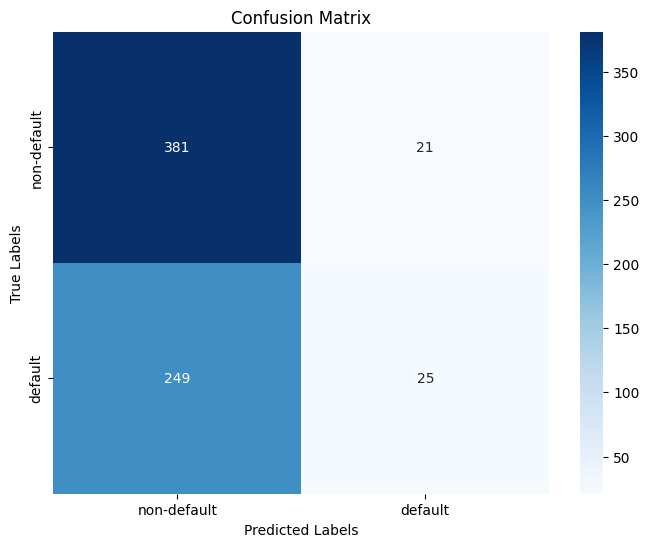

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_valid, predictions_test)

# Define custom labels
custom_labels = ['non-default', 'default']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=custom_labels, yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()